In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install catboost

     |████████████████████████████████| 67.3MB 57kB/s 


In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [33]:
data_path='/content/drive/MyDrive/Cola/open/'
train=pd.read_csv(data_path+'train.csv')
test=pd.read_csv(data_path+'test.csv')
submission=pd.read_csv(data_path+'sample_submission.csv')

In [34]:
train.head()

index gender car reality  ...   occyp_type  family_size begin_month credit
0      0      F   N       N  ...          NaN          2.0        -6.0    1.0
1      1      F   N       Y  ...     Laborers          3.0        -5.0    1.0
2      2      M   Y       Y  ...     Managers          2.0       -22.0    2.0
3      3      F   N       Y  ...  Sales staff          2.0       -37.0    0.0
4      4      F   Y       Y  ...     Managers          2.0       -26.0    2.0

[5 rows x 20 columns]

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [36]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1) #그냥 드랍해버림

In [37]:
train['gender'] = train['gender'].replace(['F','M'],[0,1]) #binary
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


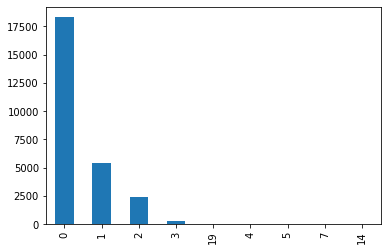

In [38]:
train['child_num'].value_counts(sort=False).plot.bar()

In [39]:
train.loc[train['child_num'] >= 2,'child_num']=2 #자녀수 2 이상은 2
test.loc[test['child_num']>=2, 'child_num']=2

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


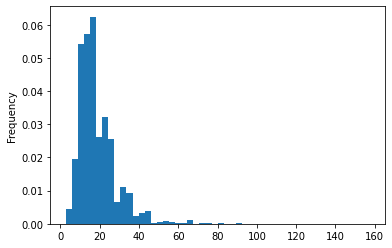

In [40]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [55]:
train['income_total'].head()

0    0
1    0
2    1
3    0
4    0
Name: income_total, dtype: int64

In [42]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [43]:
test

index  gender  car  reality  ...  phone email family_size begin_month
0     26457       1    1        0  ...      1     0         2.0       -60.0
1     26458       0    0        1  ...      1     0         2.0       -36.0
2     26459       0    0        1  ...      1     0         2.0       -40.0
3     26460       1    1        0  ...      0     0         2.0       -41.0
4     26461       0    1        1  ...      0     0         2.0        -8.0
...     ...     ...  ...      ...  ...    ...   ...         ...         ...
9995  36452       0    1        1  ...      1     0         2.0       -19.0
9996  36453       1    1        1  ...      0     0         2.0       -34.0
9997  36454       0    0        1  ...      0     0         2.0       -55.0
9998  36455       0    1        0  ...      1     0         2.0       -33.0
9999  36456       0    0        1  ...      0     1         2.0       -11.0

[10000 rows x 18 columns]

In [44]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

In [45]:
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [46]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [47]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [48]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 18)
(19842, 1)
Validation set: 
(6615, 18)
(6615, 1)
log_loss: 1.0553355235418638


In [50]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:1.04958659090833
FOLD 1 : logloss:1.0620392231517992
FOLD 2 : logloss:1.084425545901285
FOLD 3 : logloss:1.0194270422791083
FOLD 4 : logloss:1.0672811546705525
Mean:1.056551911382215


In [51]:
my_submission

array([[0.112, 0.196, 0.692],
       [0.09 , 0.218, 0.692],
       [0.06 , 0.252, 0.688],
       ...,
       [0.08 , 0.114, 0.806],
       [0.086, 0.408, 0.506],
       [0.132, 0.362, 0.506]])

In [27]:
submission

index  0  1  2
0     26457  0  0  0
1     26458  0  0  0
2     26459  0  0  0
3     26460  0  0  0
4     26461  0  0  0
...     ... .. .. ..
9995  36452  0  0  0
9996  36453  0  0  0
9997  36454  0  0  0
9998  36455  0  0  0
9999  36456  0  0  0

[10000 rows x 4 columns]